In [234]:
import climlab as cl
import os
import numpy as np
import matplotlib.pyplot as plt
import climlab
from climlab import constants as constants
import sys
import xarray as xr
import pdb
import copy as cp
outpath='/Users/adelehebertlajoie/Desktop/labo3/expe3/figures/' # repertoire pour les figures

In [235]:
''' Analyse 1 - Modèle 0D '''

' Analyse 1 - Modèle 0D '

In [238]:
#definition d'un modèle simplifié pour obtenir les températures
def temperature_0D(S0,a,sigma,epsilon_s,epsilon_a):
    ''' Calcul de la température de surface et de l'air pour une Terre dans atmosphère'''
    T_s=(((1-a)*S0)/(4*sigma*(epsilon_s-epsilon_a/2)))**0.25
    T_a=((epsilon_s*(T_s**4))/2)**0.25
    return T_s, T_a

In [240]:
# voir si la définition sort les bonnes valeurs selon les paramètres donnés
T_s,T_a=temperature_0D(1365,0.3,5.67e-8,1,0.77)

print(f"Température de surface : {T_s-273.15:.2f}°C")
print(f"Température de l'atmosphère : {T_a-273.15:.2f}°C")

Température de surface : 14.54°C
Température de l'atmosphère : -31.23°C



 
 ********************************************
Sensitivité à l'albédo et à l'émissivité - Modèle 0D 
********************************************
output figure:  /Users/adelehebertlajoie/Desktop/labo3/expe3/figures/fig.png


<function matplotlib.pyplot.show(close=None, block=None)>

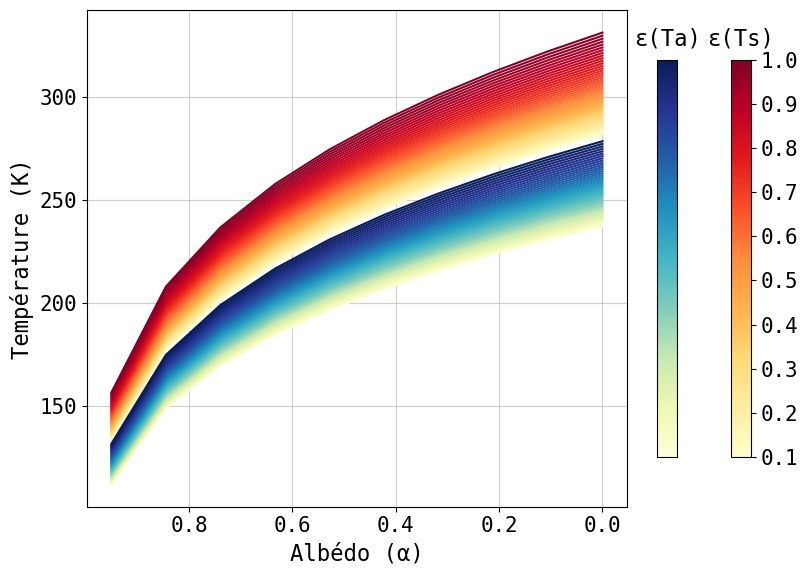

In [242]:
#figure de sensibilité à l'albédo et à l'émissivité
print('\n','\n','********************************************')
print("Sensitivité à l'albédo et à l'émissivité - Modèle 0D ")
print('********************************************')

#paramètres et couleur des colorbars
plt.figure(figsize=(8, 6))
epsilon = np.linspace(0.1, 1, 50)
albedos = np.linspace(0, 0.95, 10)
color_s = plt.cm.YlOrRd(np.linspace(0, 1, len(epsilon)))  # Ts
color_a = plt.cm.YlGnBu(np.linspace(0, 1, len(epsilon)))    # Ta

# Tracé des courbes
for i, eps in enumerate(epsilon):
    Ts_list = []
    Ta_list = []
    for alb in albedos:
        Ts, Ta = temperature_0D(1365, alb, 5.67e-8, 1, eps) #utilisation de la définition
        Ts_list.append(Ts)
        Ta_list.append(Ta)
    plt.plot(albedos, Ta_list, '-', color=color_a[i]) 
    plt.plot(albedos, Ts_list, '-', color=color_s[i])
#éléments de la figure
plt.xlabel("Albédo (α)",fontsize=16)
plt.ylabel("Température (K)",fontsize=16)
plt.grid(True, linestyle='-', alpha=0.6)
plt.tight_layout()
plt.gca().invert_xaxis()

# Colorbar pour Ts
sm_s = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin=epsilon[0], vmax=epsilon[-1]))
sm_s.set_array([])
cbar_s = plt.colorbar(sm_s, ax=plt.gca(), pad=0.06,fraction=0.05, shrink=0.8)
cbar_s.ax.set_title('ε(Ts)', fontsize=16, pad=10)

# Colorbar pour Ta
sm_a = plt.cm.ScalarMappable(cmap=plt.cm.YlGnBu, norm=plt.Normalize(vmin=epsilon[0], vmax=epsilon[-1]))
sm_a.set_array([])
cbar_a = plt.colorbar(sm_a, ax=plt.gca(), pad=0.05,fraction=0.055, shrink=0.8)
cbar_a.set_ticks([])  
cbar_a.ax.set_title('ε(Ta)', fontsize=16, pad=10) 

# enregistrement
fig_name=outpath+'fig.png'
plt.savefig(fig_name,bbox_inches='tight')
print('output figure: ', fig_name)
plt.show

In [244]:
''' Analyse 1 - Modèle 1D '''

' Analyse 1 - Modèle 1D '

In [246]:
# Pour fixer la taille de la police partout
import matplotlib as matplotlib
font = {'family' : 'monospace',
        'size'   : 15}
matplotlib.rc('font', **font)

In [248]:
units=r'W m$^{-2}$' # Unités puisance
alb=0.25 # Albedo surface
levels=np.arange(200,330,20)
levels=[298]
Tlims=[180,310]
Nz=30 # nombre de niveaux verticaux

In [250]:
# Load the reference vertical temperature profile from the NCEP reanalysis
ncep_lev=np.load('/Users/adelehebertlajoie/Desktop/labo3/expe3/Experience3_fichiers/npy/ncep_lev.npy')
ncep_T=np.load('/Users/adelehebertlajoie/Desktop/labo3/expe3/Experience3_fichiers/npy/ncep_T.npy')+273.15

In [252]:
#création d'une définition pour une modèle radiatif seulement
def rad_rcm(state=None):
    if state is None:
        state = climlab.column_state(num_lev=30)
    h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
    rad = climlab.radiation.RRTMG(name='Radiation', state=state, specific_humidity=h2o.q, albedo=alb)
    rcm = climlab.couple([rad, h2o], name='Radiative-Convective Model')
    return rcm


 
 ********************************************
Control simulation 
********************************************
output figure:  /Users/adelehebertlajoie/Desktop/labo3/expe3/figures/fig1.png


<function matplotlib.pyplot.show(close=None, block=None)>

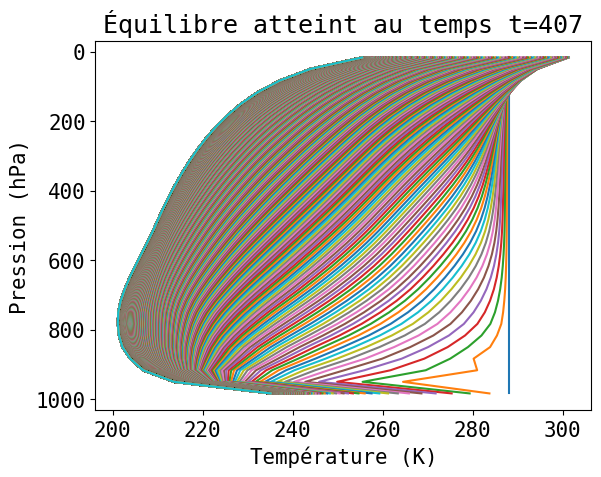

In [260]:
rcm = rad_rcm()

print('\n','\n','********************************************')
print('Control simulation ')
print('********************************************')

# Make the initial state isothermal
rcm.Tatm[:] = rcm.Ts
T=[]
q=[]
tr=[]

# Plot temperature
for t in range(1000):
    T.append(cp.deepcopy(rcm.Tatm))
    q.append(cp.deepcopy(rcm.q))
    plt.plot(rcm.Tatm,rcm.lev[::-1])
    rcm.step_forward() #run the model forward one time step
    if abs(rcm.ASR - rcm.OLR)<1: # in W/m2
        tr.append(t)
        
#éléments de la figure
plt.title('Équilibre atteint au temps t='+str(tr[0]))
plt.xlabel('Température (K)')
plt.ylabel('Pression (hPa)')
plt.gca().invert_yaxis()

#enregistrement de la figure
fig_name=outpath+'fig1.png'
plt.savefig(fig_name,bbox_inches='tight')
print('output figure: ', fig_name)
plt.show

output figure:  /Users/adelehebertlajoie/Desktop/labo3/expe3/figures/fig2.png


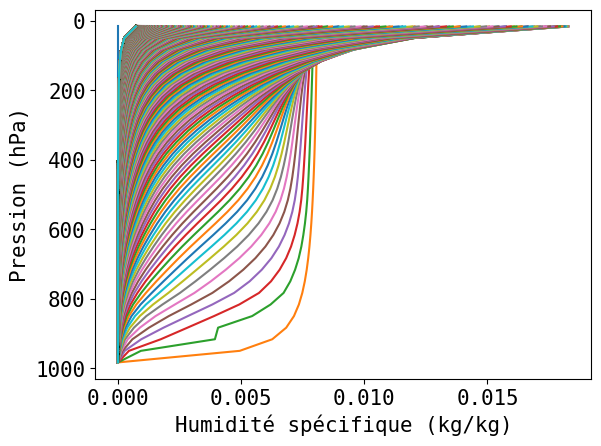

In [264]:
#Plot humidity
for t in range(1000):
    plt.plot(q[t],rcm.lev[::-1])
plt.xlabel('Humidité spécifique (kg/kg)')
plt.ylabel('Pression (hPa)')
fig_name=outpath+'fig2.png'
plt.gca().invert_yaxis()

#enregistrement de la figure
plt.savefig(fig_name,bbox_inches='tight')
plt.show
print('output figure: ', fig_name)


 
 ********************************************
Comparaison des profils de température
 du Modèle RCM et de la réanalyse NCEP 
********************************************
output figure:  /Users/adelehebertlajoie/Desktop/labo3/expe3/figures/fig3.png


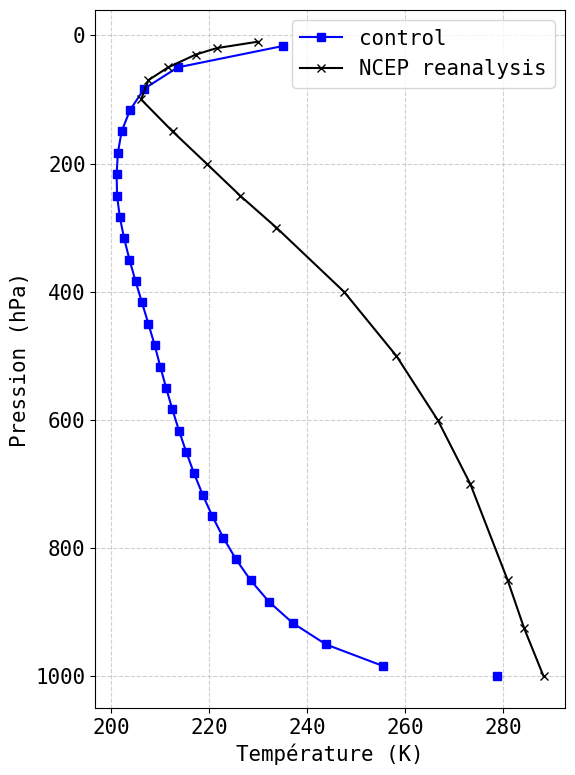

In [266]:
print('\n','\n','********************************************')
print('Comparaison des profils de température\n du Modèle RCM et de la réanalyse NCEP ')
print('********************************************')

# données de réanalyse
ncep_lev = np.load('ncep_lev.npy')
ncep_T = np.load('ncep_T.npy') + 273.15  # en Kelvin

# Comparaison graphique et tracé de courbes
plt.figure(figsize=(6, 8))
plt.plot(rcm.Tatm[::-1], rcm.lev[::-1], marker='s',color='b',label='control')
plt.plot(rcm.Ts, 1000,color='b',marker='s')
plt.plot(ncep_T, ncep_lev, marker='x',color='k',label='NCEP reanalysis')

#éléments du graphique
plt.gca().invert_yaxis()
plt.xlabel('Température (K)')
plt.ylabel('Pression (hPa)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

#enregistrement de la figure
fig_name=outpath+'fig3.png'
plt.savefig(fig_name,bbox_inches='tight')
plt.show
print('output figure: ', fig_name)
plt.show()


In [268]:
''' Analyse 2 - Modèle 1D-Sensibilité de l'atmosphère aux variations des concentrations de gaz'''

" Analyse 2 - Modèle 1D-Sensibilité de l'atmosphère aux variations des concentrations de gaz"


 
 ********************************************
Sensibilité de l'atmosphère aux variations des concentrations de gaz
********************************************
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 s

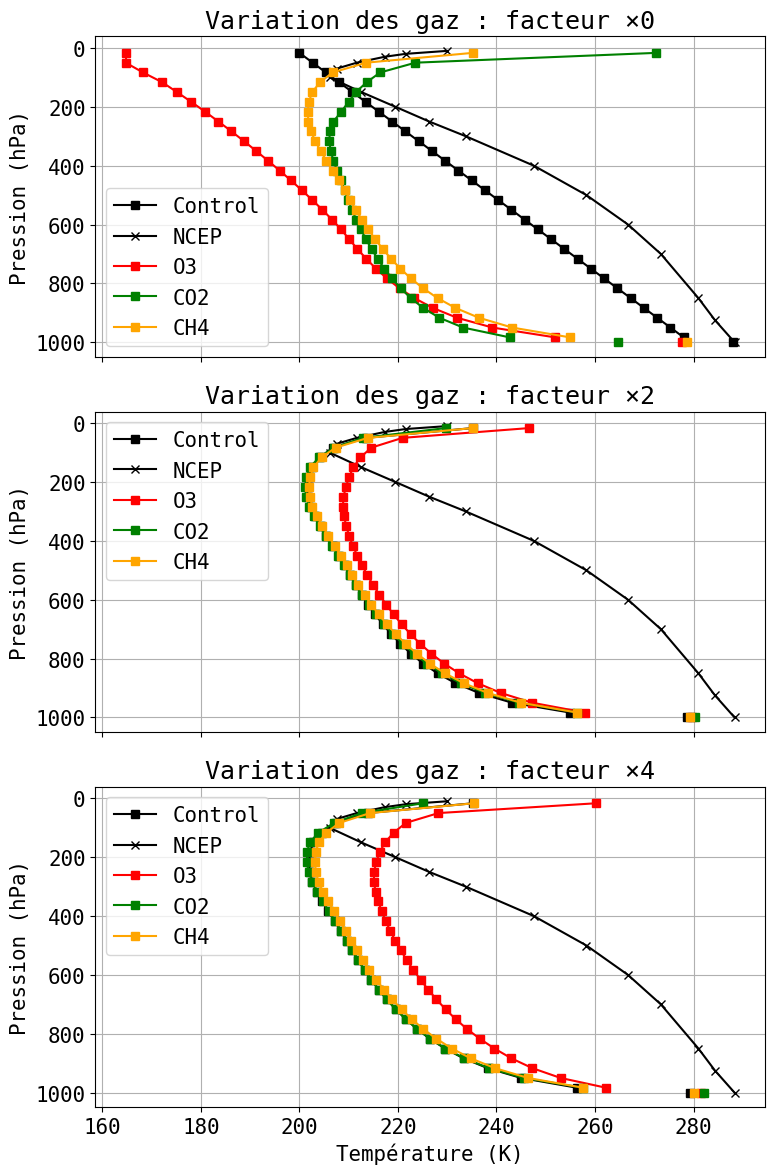

In [272]:
print('\n','\n','********************************************')
print("Sensibilité de l'atmosphère aux variations des concentrations de gaz")
print('********************************************')

rcm=rad_rcm()
# Création de la figure
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 12), sharex=True)
colors = ['k', 'r', 'g', 'orange']
ii = [0, 2, 4] #facteur de multiplication

#boucle à troix axes
for ax, i in zip(axs, ii):
    ax.plot(rcm.Tatm[::-1], rcm.lev[::-1], marker='s', color=colors[0], label='Control')
    ax.plot(rcm.Ts, 1000, marker='s', color=colors[0])
    ax.plot(ncep_T, ncep_lev, marker='x', color='k', label='NCEP')

    # boucle sur les gaz
    for gi, gaz in enumerate(['O3', 'CO2', 'CH4']):
        rcm=rad_rcm()
        if i == 0:
            rcm.absorber_vmr[gaz] = 0 # retrait du gaz
        else:
            rcm.absorber_vmr[gaz] *= i #multiplication par facteur
        rcm.integrate_years(2)

        ax.plot(rcm.Tatm[::-1], rcm.lev[::-1], marker='s',color=colors[gi + 1],label=f"{gaz}") #tracé de courbe
        ax.plot(rcm.Ts, 1000, marker='s', color=colors[gi + 1])

    #éléments de graphique
    ax.set_title(f"Variation des gaz : facteur ×{i}")
    ax.set_ylabel("Pression (hPa)")
    ax.invert_yaxis()
    ax.grid(True)
    ax.legend(loc='best')
    
# axe x commun
axs[-1].set_xlabel("Température (K)")

#enregistrement graphique
plt.tight_layout()
fig_name = outpath + 'fig4.png'
print('Output figure :', fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()


Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Différence de température de surface: [1.46127519] °C
output figure:  /Users/adelehebertlajoie/Desktop/labo3/expe3/figures/fig5.png


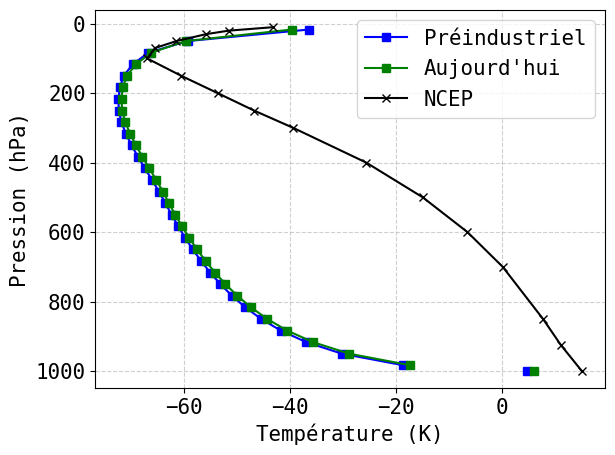

In [274]:
# dico des concentrations du préindustrielle
preind = {'CO2':280e-6, 'CH4':0.8e-6}  
rcm_pi = rad_rcm() #utilisation de la définition
# boucle sur les gaz
for gaz, i in preind.items():
    rcm_pi.absorber_vmr[gaz] = i
    rcm_ajd.absorber_vmr['O3'] *=1 #on ne modifie pas l'ozone
rcm_pi.integrate_years(2)

#dico des concentrations d'aujourd'hui
ajd = {'CO2':422.8e-6, 'CH4':1.93e-6}  
rcm_ajd = create_rcm() #utilisation de la définition
# boucle sur les gaz
for gaz, i in ajd.items():
    rcm_ajd.absorber_vmr[gaz] = i
    rcm_ajd.absorber_vmr['O3'] *=1 #on ne modifie pas l'ozone
rcm_ajd.integrate_years(2)

#tracé des courbes 
plt.plot(rcm_pi.Tatm[::-1]-273.15, rcm_pi.lev[::-1],marker='s', color='b', label='Préindustriel')
plt.plot(rcm_pi.Ts-273.15, 1000,marker='s', color='b')
plt.plot(rcm_ajd.Tatm[::-1]-273.15, rcm_ajd.lev[::-1],marker='s', color='g', label="Aujourd'hui")
plt.plot(rcm_ajd.Ts-273.15, 1000,marker='s', color='g')
plt.plot(ncep_T-273.15, ncep_lev, marker='x', color='k', label='NCEP')

#calcul de la différence de température de surface
Ts = rcm_ajd.Ts - rcm_pi.Ts
print("Différence de température de surface:",Ts,"°C")

#éléments du graphique
plt.gca().invert_yaxis()
plt.xlabel('Température (K)')
plt.ylabel('Pression (hPa)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

#enregistrement 
fig_name=outpath+'fig5.png'
plt.savefig(fig_name,bbox_inches='tight')
plt.show
print('output figure: ', fig_name)

In [ ]:
'''' Analyse 2 - Modèle 1D-Sensibilité de l'atmosphère aux variations de l’albedo de surface''''


 
 ********************************************
Sensitivité à l'albédo
********************************************
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
output figure:  /Users/adelehebertlajoie/Desktop/labo3/expe3/figures/fig6.png


<function matplotlib.pyplot.show(close=None, block=None)>

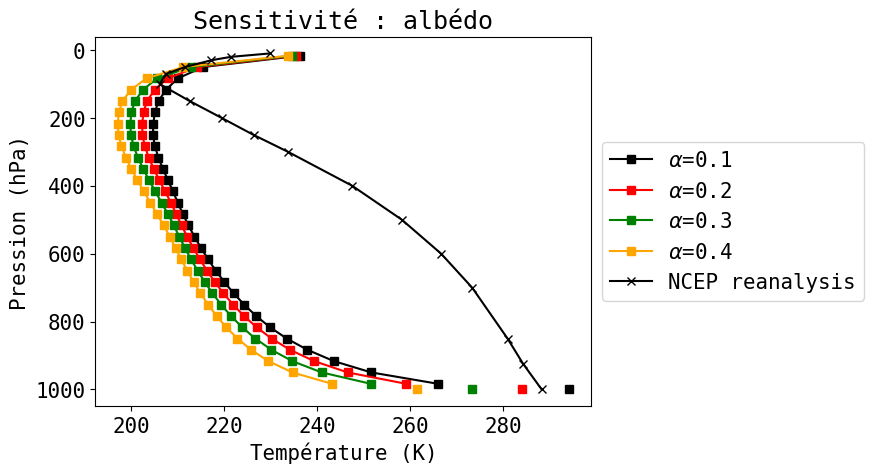

In [276]:
print('\n','\n','********************************************')
print("Sensitivité à l'albédo")
print('********************************************')

#range d'albédo
albedos=np.arange(.1,.4,.1)
rcms={}
#boucle 
for alb in albedos:
    rcm=rad_rcm()
    rcms['rcm'+str(alb)]=rcm  #stockage de rcm à différents albédos
    
#boucle pour intégrer sur deux ans chaque simulations et tracé de courbes
for ai,alb in enumerate(albedos):
    rcms['rcm'+str(alb)].integrate_years(2)
    plt.plot(rcms['rcm'+str(alb)].Tatm[::-1], rcm.lev[::-1], marker='s', label=r'$\alpha$='+str(np.round(alb,1)),color=colors[ai])
    plt.plot(rcms['rcm'+str(alb)].Ts, 1000, marker='s',color=colors[ai])
#tracé de la réanalyse
plt.plot(ncep_T, ncep_lev, marker='x',color='k',label='NCEP reanalysis')
#éléments du graphique
plt.gca().invert_yaxis()
plt.title('Sensitivité : albédo')
plt.ylabel('Pression (hPa)')
plt.xlabel('Température (K)')
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

#enregistrement
fig_name=outpath+'fig6.png'
print('output figure: ', fig_name)
plt.savefig(fig_name,bbox_inches='tight')

plt.show

In [282]:
# Modèle de base
alb=.25
rcm=rad_rcm()
rcm.integrate_years(2)    
print("température de surface controle:",rcm.Ts)

rcm_CO2=rad_rcm()
rcm_CO2.absorber_vmr['CO2'] *= 2   # double la concentration de CO2
rcm_CO2.integrate_years(2) 
print("température de surface CO2 X2 :",rcm_CO2.Ts)

# Différence de température de surface
delta_Ts = rcm_CO2.Ts - rcm.Ts
print("Réchauffement de surface avec doublement de CO2 :", delta_Ts, "°C")


Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
température de surface controle: [278.76475474]
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
température de surface CO2 X2 : [280.39136974]
Réchauffement de surface avec doublement de CO2 : [1.62661501] °C


In [320]:
# Recherche de l'albédo compensateur ### pu bon, je ne retrouve pas la valeur que j'avais de 0.4
albedos = np.arange(0.1, 0.41, 0.05)
alb_recherche = None
min_diff = 1e6

for alb in albedos:
    rcm_test = rad_rcm()
    rcm_test.subprocess['Radiation'].albedo = alb
    rcm_test.integrate_years(2)
    diff = abs(rcm_test.Ts - rcm_CO2.Ts)
    if diff < min_diff:
        min_diff = diff
        alb_recherche = alb
        Ts_match = rcm_test.Ts

print("Albédo compensateur :", alb_recherche)
print("Température de surface correspondante :", Ts_match)


Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 3.997347513512951 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 3.997347513512951 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 3.997347513512951 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 3.997347513512951 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 3.997347513512951 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 3.997347513512951 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 3.997347513512951 years.
Albédo compensateur : 0.1
Température de surface correspondante : [294.15118835]


In [32]:
''' Analyse 3 - Modèle 1D radiatif et convectif '''

' Analyse 3 - Modèle 1D radiatif et convectif '

In [328]:
#création d'une définition avec convection et radiation
def conv_rcm(adj_lapse_rate):
    state = climlab.column_state(num_lev=30)
    h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
    rad = climlab.radiation.RRTMG(name='Radiation', state=state, specific_humidity=h2o.q, albedo=alb)
    conv = climlab.convection.ConvectiveAdjustment(name='Convection', state=state, adj_lapse_rate=adj_lapse_rate)
    rcm = climlab.couple([rad,conv,h2o], name='Radiative-Convective Model')
    return rcm


 
 ********************************************
Sensibilité à la convection
********************************************
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
output figure:  /Users/adelehebertlajoie/Desktop/labo3/expe3/figures/fig7.png


<function matplotlib.pyplot.show(close=None, block=None)>

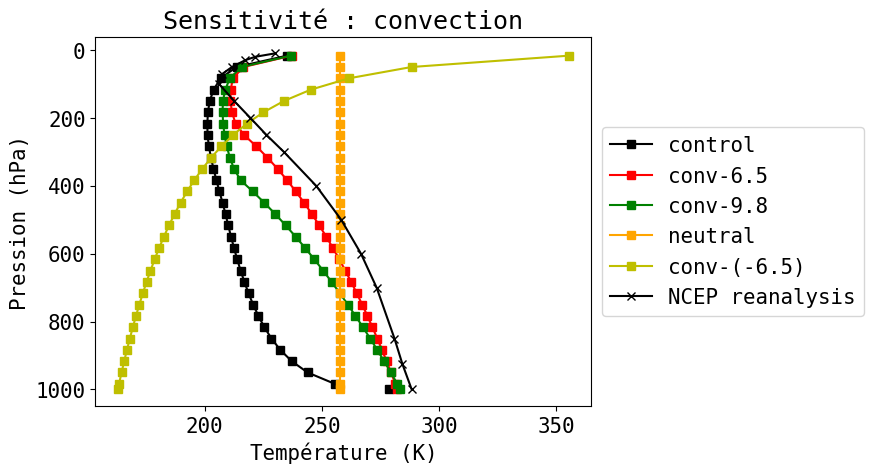

In [342]:
print('\n','\n','********************************************')
print('Sensibilité à la convection')
print('********************************************')
alb=.25
colors=['k','r','g','orange','y']

#ensmeble des rcm convectif avec lapse rate différents en utilisant la défnition crée
rcms={}
rcms['rcm0'] = rad_rcm()
rcms['rcm1'] = conv_rcm(6.5)
rcms['rcm2'] = conv_rcm(9.8)
rcms['rcm3'] = conv_rcm(0)
rcms['rcm4'] = conv_rcm(-6.5)

#tracé des courbes instables, neutre et stables
mod_name=['control','conv-6.5','conv-9.8','neutral','conv-(-6.5)']
for ai in range(5):
    rcms['rcm'+str(ai)].integrate_years(2)
    plt.plot(rcms['rcm'+str(ai)].Tatm[::-1], rcm.lev[::-1], marker='s', label=mod_name[ai],color=colors[ai])
    plt.plot(rcms['rcm'+str(ai)].Ts, 1000, marker='s',color=colors[ai])
#tracé de la réanalyse
plt.plot(ncep_T, ncep_lev, marker='x',color='k',label='NCEP reanalysis')
#éléments du graphique
plt.gca().invert_yaxis()
plt.title('Sensitivité : convection')
plt.ylabel('Pression (hPa)')
plt.xlabel('Température (K)')
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
#enregistrement
fig_name=outpath+'fig7.png'
print('output figure: ', fig_name)
plt.savefig(fig_name,bbox_inches='tight')
plt.show


In [343]:
print('\n','\n','********************************************')
print('Flux radiatifs')
print('********************************************')

mod_name=['control','conv-6.5','conv-9.8','neutral','conv-(-6.5)']
for ai in range(5):
    rcms['rcm'+str(ai)].integrate_years(2)
    RCM = rcms['rcm'+str(ai)] #output des différents rayonnement selon le lapse rate
    SW_up = RCM.SW_flux_up
    SW_down = RCM.SW_flux_down
    LW_up = RCM.LW_flux_up
    LW_down = RCM.LW_flux_down
    print(mod_name[ai])
    print(f"solaire entrant: {SW_down[0]:.2f} W/m²")
    print(f"solaire réfléchi: {SW_up[0]:.2f} W/m²")
    print(f"solaire absorbé par l'atmosphère: {SW_down[0] - SW_down[-1] - SW_up[0]:.2f} W/m²")
    print(f"solaire absorbé par la surface: {SW_down[-1] - SW_up[-1]:.2f} W/m²")
    print(f"IR sortant: {LW_up[0]:.2f} W/m²")
    print(f"IR descendant à la surface: {LW_down[-1]:.2f} W/m²")
    print(f"IR émis par la surface: {LW_up[-1]:.2f} W/m²")
    print("\n")



 
 ********************************************
Flux radiatifs
********************************************
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 3.997347513512951 years.
control
solaire entrant: 341.30 W/m²
solaire réfléchi: 98.17 W/m²
solaire absorbé par l'atmosphère: -18.92 W/m²
solaire absorbé par la surface: 196.54 W/m²
IR sortant: 243.13 W/m²
IR descendant à la surface: 145.84 W/m²
IR émis par la surface: 342.38 W/m²


Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 3.997347513512951 years.
conv-6.5
solaire entrant: 341.30 W/m²
solaire réfléchi: 89.47 W/m²
solaire absorbé par l'atmosphère: 22.03 W/m²
solaire absorbé par la surface: 172.35 W/m²
IR sortant: 251.83 W/m²
IR descendant à la surface: 263.60 W/m²
IR émis par la surface: 359.86 W/m²


Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 3.997347513512951 years.
conv-9.8
solaire entrant: 341.30 W/m²
solaire réfléchi: 90.30 W/m²
solai

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986

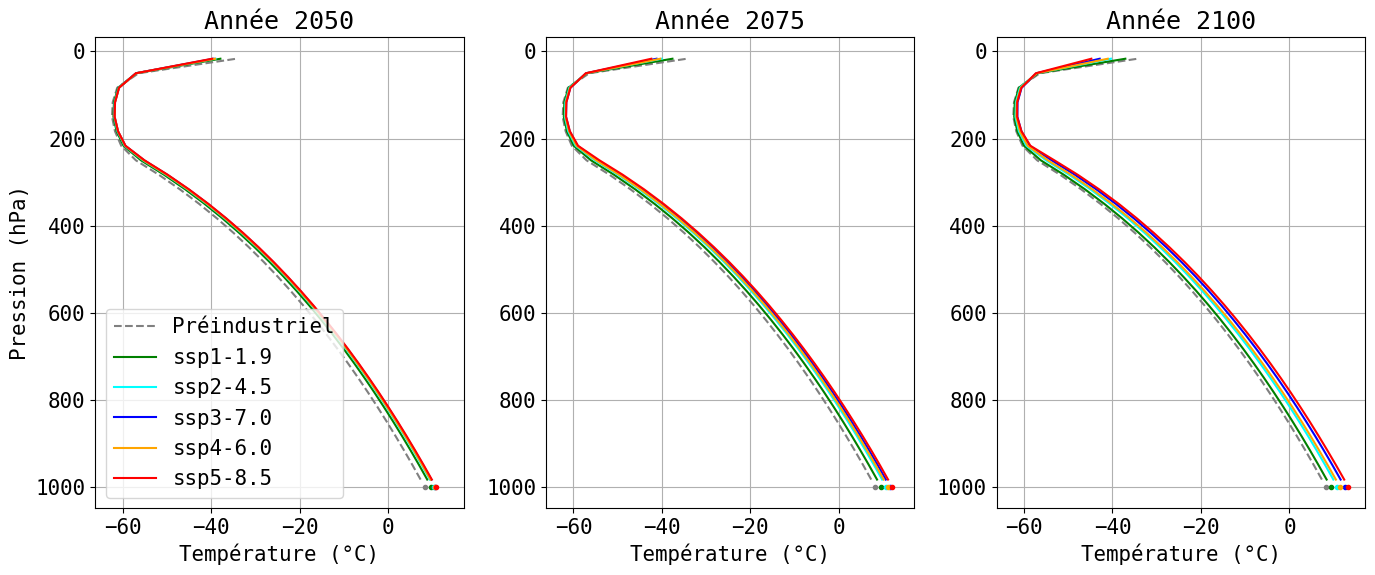

In [336]:
# Création de la figure bonus
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 6), sharex=True)
ssp_colors = {
    'ssp1-1.9':'green',
    'ssp2-4.5':'cyan',
    'ssp3-7.0':'b',
    'ssp4-6.0':'orange',
    'ssp5-8.5':'red'
}

# données de concentrations SSP 
ssp_scenariosCO2 = {
    'ssp1-1.9': { 2050: 437.6, 2075: 419.7, 2100: 393.5},
    'ssp2-4.5': { 2050: 506.9, 2075: 575.5, 2100: 602.8},
    'ssp3-7.0': { 2050: 540.6, 2075: 683.0, 2100: 867.2},
    'ssp4-6.0': { 2050: 515.6, 2075: 606.9, 2100: 668.4},
    'ssp5-8.5': { 2050: 562.8, 2075: 801.7, 2100: 1135.2}
}
ssp_scenariosCH4 = {
    'ssp1-1.9': { 2050: 1.428, 2075: 1.184, 2100: 1.036},
    'ssp2-4.5': { 2050: 2.020, 2075: 1.815, 2100: 1.683},
    'ssp3-7.0': { 2050: 2.472, 2075: 2.934, 2100: 3.372},
    'ssp4-6.0': { 2050: 2.503, 2075: 2.688, 2100: 2.645},
    'ssp5-8.5': { 2050: 2.446, 2075: 2.672, 2100: 2.415}
}

year = [2050,2075,2100]  # années

#réintégrer la courbe préindustrielle mais avec convection
# dico des concentrations du préindustrielle
preind = {'CO2':280e-6, 'CH4':0.8e-6}  
rcm_pi = conv_rcm(6.5) #utilisation de la définition
# boucle sur les gaz
for gaz, i in preind.items():
    rcm_pi.absorber_vmr[gaz] = i
    rcm_ajd.absorber_vmr['O3'] *=1 #on ne modifie pas l'ozone
rcm_pi.integrate_years(2)

# boucle sur trois axes
for ax, y in zip(axs, year):
    #tracé courbe pi
    ax.plot(rcm_pi.Tatm[::-1] - 273.15,rcm_pi.lev[::-1],linestyle='--',color='grey',label='Préindustriel')
    ax.plot(rcm_pi.Ts-273.15, 1000,marker='o',markersize=3,color='grey')
    #boucle avec les différents ssp
    for ssp in ['ssp1-1.9', 'ssp2-4.5', 'ssp3-7.0','ssp4-6.0', 'ssp5-8.5']: 
        rcm_ssp = conv_rcm(6.5) #utilisation de la définition
        CO2 = ssp_scenariosCO2[ssp][y] #clé CO2 selon l'année et ssp
        CH4 = ssp_scenariosCH4[ssp][y] #clé CH4 selon l'année et ssp
        ssp_c= {'CO2':CO2*1e-6, 'CH4':CH4*1e-6} 
        for gaz, i in ssp_c.items():
            rcm_ssp.absorber_vmr[gaz] = i #ajout de la concentration
            rcm_ssp.absorber_vmr['O3'] *= 1 #ozone non-modifiée
        rcm_ssp.integrate_years(2)
        ax.plot(rcm_ssp.Tatm[::-1] - 273.15,rcm_ssp.lev[::-1],color=ssp_colors[ssp],label=ssp) #tracé
        ax.plot(rcm_ssp.Ts-273.15, 1000,marker='o',markersize=3,color=ssp_colors[ssp])

#éléments de graphique
    ax.set_title(f"Année {y}")
    ax.set_xlabel("Température (°C)")
    ax.invert_yaxis()
    ax.grid(True)
    
    
# axe x commun
axs[0].set_ylabel("Pression (hPa)")
axs[0].legend(loc='best')
#enregistrement graphique
plt.tight_layout()
fig_name = outpath + 'figbonus.png'
print('Output figure :', fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986

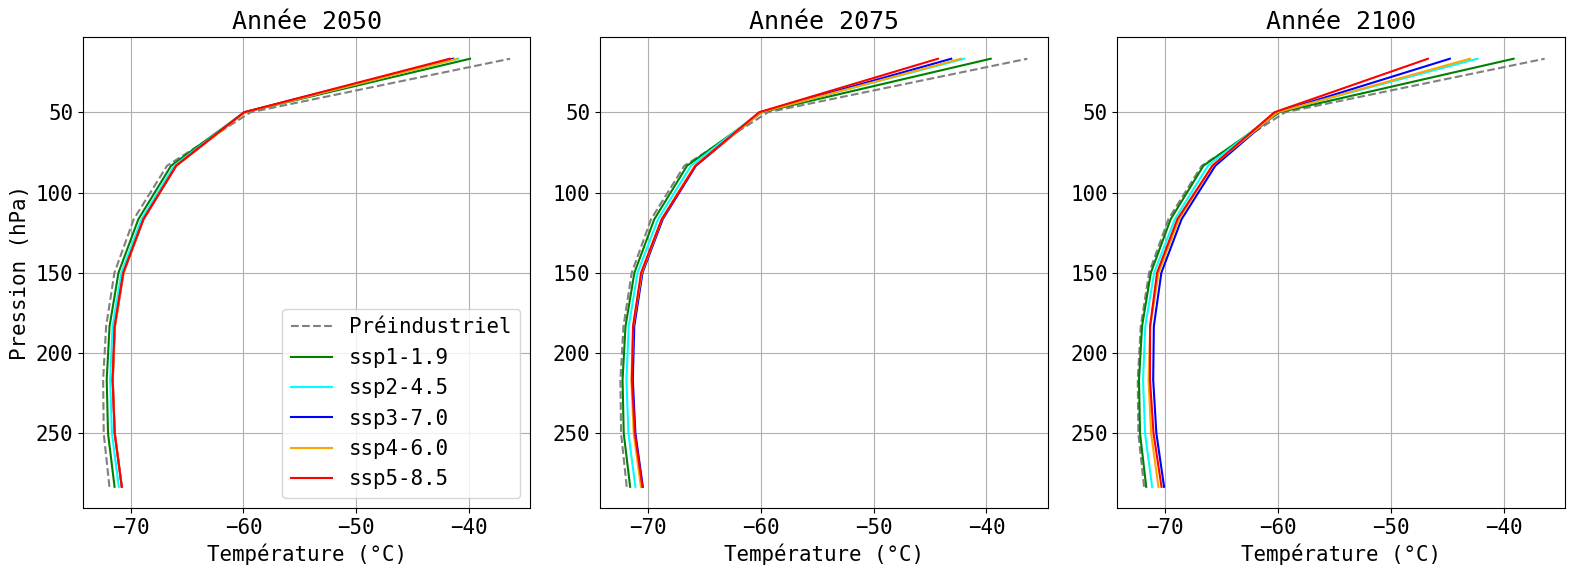

In [204]:
#même chose qu'en haut mais pour haute atmosphère
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), sharex=True)

# boucle sur trois axes
for ax, y in zip(axs, year):
    #tracé courbe pi
    mask = (rcm_pi.lev[::-1] <= 300) & (rcm_pi.lev[::-1] >= 0)
    ax.plot(rcm_pi.Tatm[::-1][mask] - 273.15,rcm_pi.lev[::-1][mask],linestyle='--',color='grey',label='Préindustriel')
    #boucle avec les différents ssp
    for ssp in ['ssp1-1.9', 'ssp2-4.5', 'ssp3-7.0','ssp4-6.0', 'ssp5-8.5']: 
        rcm_ssp = conv_rcm(6.5) #utilisation de la définition
        CO2 = ssp_scenariosCO2[ssp][y] #clé CO2 selon l'année et ssp
        CH4 = ssp_scenariosCH4[ssp][y] #clé CH4 selon l'année et ssp
        ssp_c= {'CO2':CO2*1e-6, 'CH4':CH4*1e-6} 
        for gaz, i in ssp_c.items():
            rcm_ssp.absorber_vmr[gaz] = i #ajout de la concentration
            rcm_ssp.absorber_vmr['O3'] *= 1 #ozone non-modifiée
        rcm_ssp.integrate_years(2)
        mask = (rcm_ssp.lev[::-1] <= 300) & (rcm_ssp.lev[::-1] >= 0)
        ax.plot(rcm_ssp.Tatm[::-1][mask] - 273.15,rcm_ssp.lev[::-1][mask],color=ssp_colors[ssp],label=ssp)

#éléments de graphique
    ax.set_title(f"Année {y}")
    ax.set_xlabel("Température (°C)")
    ax.invert_yaxis()
    ax.grid(True)
    
# axe x commun
axs[0].set_ylabel("Pression (hPa)")
axs[0].legend(loc='best')
#enregistrement graphique
plt.tight_layout()
fig_name = outpath + 'figbonus2.png'
print('Output figure :', fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986

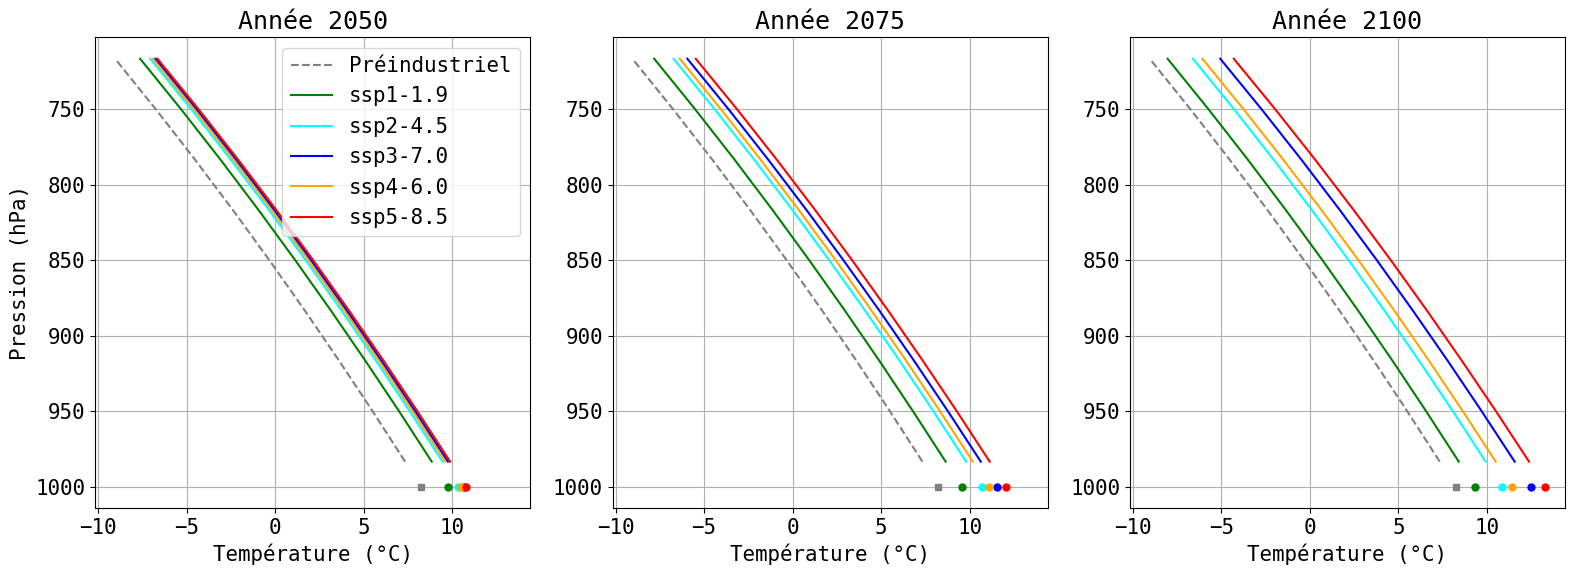

In [338]:
#même chose qu'en haut mais pour basse atmosphère
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), sharex=True)

# boucle sur trois axes
for ax, y in zip(axs, year):
    #tracé courbe pi
    mask = (rcm_pi.lev[::-1] <= 1000) & (rcm_pi.lev[::-1] >= 700) #mask 
    ax.plot(rcm_pi.Tatm[::-1][mask] - 273.15,rcm_pi.lev[::-1][mask],color='grey',linestyle='--',label='Préindustriel')
    ax.plot(rcm_pi.Ts-273.15, 1000,marker='s',markersize=5, color='grey')
    #boucle avec les différents ssp
    for ssp in ['ssp1-1.9', 'ssp2-4.5', 'ssp3-7.0','ssp4-6.0', 'ssp5-8.5']: 
        rcm_ssp = conv_rcm(6.5) #utilisation de la définition
        CO2 = ssp_scenariosCO2[ssp][y] #clé CO2 selon l'année et ssp
        CH4 = ssp_scenariosCH4[ssp][y] #clé CH4 selon l'année et ssp
        ssp_c= {'CO2':CO2*1e-6, 'CH4':CH4*1e-6} 
        for gaz, i in ssp_c.items():
            rcm_ssp.absorber_vmr[gaz] = i #ajout de la concentration
            rcm_ssp.absorber_vmr['O3'] *= 1 #ozone non-modifiée
        rcm_ssp.integrate_years(2)
        mask = (rcm_ssp.lev[::-1] <= 1000) & (rcm_ssp.lev[::-1] >= 700)
        ax.plot(rcm_ssp.Tatm[::-1][mask] - 273.15,rcm_ssp.lev[::-1][mask],color=ssp_colors[ssp],label=ssp)
        ax.plot(rcm_ssp.Ts-273.15, 1000,marker='o',markersize=5, color=ssp_colors[ssp])

#éléments de graphique
    ax.set_title(f"Année {y}")
    ax.set_xlabel("Température (°C)")
    ax.invert_yaxis()
    ax.grid(True)
    
# axe x commun
axs[0].set_ylabel("Pression (hPa)")
axs[0].legend(loc='best')
#enregistrement graphique
plt.tight_layout()
fig_name = outpath + 'figbonus2.png'
print('Output figure :', fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986

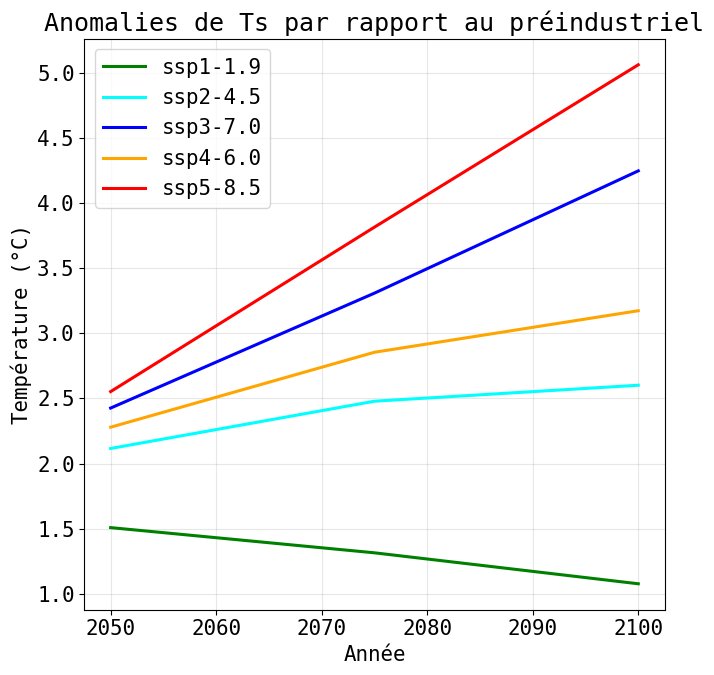

In [340]:
#figure bonus d'anomalies je m'étais trompé et j'ai présentée la mauvaise figure, donc les températures surestime légèrement la réalité
plt.figure(figsize=(7,7))

#référence
Ts_preind = rcm_pi.Ts - 273.15   

for ssp in ssp_colors.keys():
    Ts_vals = []  # stockage  des températures de surface
    #boucle pour chaque année
    for y in year:
        rcm_ssp = conv_rcm(6.5) #utilisation de la définition
        CO2 = ssp_scenariosCO2[ssp][y] #clé CO2 selon l'année et ssp
        CH4 = ssp_scenariosCH4[ssp][y] #clé CH4 selon l'année et ssp
        ssp_c= {'CO2':CO2*1e-6, 'CH4':CH4*1e-6} 
        for gaz, i in ssp_c.items():
            rcm_ssp.absorber_vmr[gaz] = i #ajout de la concentration
            rcm_ssp.absorber_vmr['O3'] *= 1 #ozone non-modifiée
        rcm_ssp.integrate_years(2)
        Ts_vals.append(rcm_ssp.Ts - 273.15)
    anomalies = np.array(Ts_vals) - Ts_preind

    # Tracé
    plt.plot(year, anomalies, color=ssp_colors[ssp], lw=2.2, label=ssp)


# élément du graphique
plt.title("Anomalies de Ts par rapport au préindustriel")
plt.xlabel("Année")
plt.ylabel("Température (°C)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
#enregistrement
fig_name = outpath + 'figbonus3.png'
print('Output figure :', fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()